In [13]:
import torch
import torch.nn.functional as F
import os, sys
from pathlib import Path
from TCN.mnist_pixel.utils import data_generator
from TCN.mnist_pixel.model import TCN
import numpy as np
import matplotlib.pyplot as plt

In [4]:
model_path = './TCN/mnist_pixel/models/default_params.pt'
data_path = './TCN/mnist_pixel//data/mnist'
batch_size = 1

_, test_loader = data_generator(data_path, batch_size)
model = TCN()
model.load_state_dict(torch.load(model_path))
model.eval()

if torch.cuda.is_available():
    model.cuda()
    
model.fast_inference(batch_size)

True Label: 7
torch.Size([1, 1, 784])


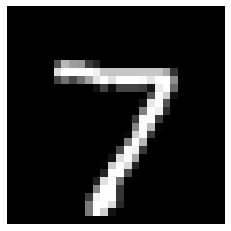

In [21]:
for data, target in test_loader:
    im = data.squeeze()
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    print(f'True Label: {target.item()}')
    
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    
    data = data.view(data.size()[0], 1, -1)
    print(data.size())
    
#     for i in range(data.size()[2]):
#         output = model.single_forward(data[:,:,i].view(data.size()[0], data.size()[1], 1))
    

    break

In [26]:
sum([2**i for i in range(7)])

127